# Projet Numérique : Câble sous-marin

#### Anisse Id-Benaddi & Simon Leconte

L'objectif de ce projet est d'estimer la longueur de câble nécessaire pour traverser une étendue d'eau dont la profondeur en chaque point nous est inconnue, lorsque le câble est posé sur le fond de l'étendue d'eau. On ne connaît que quelques profondeurs, qui correspondent à des observations ponctuelles.

On discrétise le plancher marin en $N$ points d'abscisse $x_0,...,x_N$ régulièrement espacés de $\Delta$ et de profondeur $z(x_0),...,z(x_N)$. La longueur du plancher marin réelle est donc $l=\sum_{i=1}^N \sqrt{\Delta^2+(z(x_i)-z(x_{i-1}))^2}$. Nous allons donc effectuer des simulations estimant la valeur des $z_i$. Une simulation nous donnera donc un vecteur $Z=(Z(x_0),...,Z(x_N))$. On pourra alors calculer $L$, d'espérance $l$.

## Questions théoriques

La loi des grands nombres nous autorise à estimer l'espérance conditionnelle par la moyenne empirique de simulations conditionnelles. En effet, si on effectue $n$ simulations indépendantes de la longueur du plancher océanique $L_1,L_2,...,L_n$, la loi des grands nombres nous indique que si les $L_i$ sont de mêmes lois et de carrés intégrables, la variable aléatoire $M_n = \dfrac{L_1+L_2+...+L_n}{n}$ converge presque surement et en moyenne vers $\mathbb{E}(L)$ .

D'après le cours "Probabilité IV", si on prend $Z=(Z_1,...,Z_N)$ gaussien  d'espérance $(\mu,...,\mu)$ et de matrice de covariance $C$ définie positive, $Y=(Z(x_{j_1}),...,Z(x_{j_n}))$ et $X$ contenant les éléments de $Z$ non présents dans $Y$.
$f_{X|Y=y}(\vec{x}) = \dfrac{1}{(2\pi)^{\frac{N-n+2}{2}}}*\dfrac{1}{\sqrt{\det{CS_X}}} * \exp (-\dfrac{1}{2}(x-\psi (y))^TCS_X^{-1}(x-\psi (y)) )$ où $CS_X = C_X-C_{X,Y}C_Y^{-1}C_{Y,X}$ et $\psi (y) = (\mu,...,\mu) - C_{X,Y}C_Y^{-1}(y-(\mu,...,\mu))$.

Soit $Y$ gaussien de moyenne $(0,...,0)$ et de variance $1$, de composantes indépendantes. Alors $\Phi_Y(u)=\exp (-\dfrac{1}{2}u^2)$. Si $Z=m+RY$ avec $R$ une matrice et $m$ un vecteur : $\Phi_Z(u)=e^{i<u,m>}\Phi_Y(R^Tu) = e^{i<u,m>}e^{-\frac{1}{2}(R^TR)(uu^T)}$ et donc $f_Z(z) = \mathcal{F}^{-1}(\Phi_Z)(z)$.

Ainsi, il suffit de simuler $Z=\mu+RY$ où $Y$ est de loi $\mathcal{G}(0,1)$ et où $R$ est la décomposition de Cholesky de la matrice de covariance de $Z$.

## Questions informatiques

Commençons par initialiser les données du problème :

In [30]:
import numpy as np
import math
import matplotlib.pyplot as plt


A=0.0
B=500
N=101
Delta= (B-A)/(N-1)
discretization_indexes = np.arange(N)
discretization = discretization_indexes*Delta


mu=-5
a=50
sigma2=12

observation_indexes = [0,20,40,60,80,100]
depth = np.array([0,-4,-12.8,-1,-6.5,0])

unknown_indexes=list(set(discretization_indexes)-set(observation_indexes))

La fonction suivante permet d'obtenir la covariance en fonction de la distance entre deux points, on pourra aussi donner une matrice de distance pour obtenir la matrice de covariance.

In [31]:
def covariance(d,a,v):
    return v*np.exp(-np.abs(d)/a)

Calculons la matrice de distance des points de notre espace discrétisé

In [32]:
def distance(discretization):
    n=len(discretization)
    D=np.zeros((n,n))
    for i in range(n):
        for j in range(n):
            D[i][j]=np.abs(discretization[i]-discretization[j])
    return D

distance_matrix=distance(discretization)

Nous obtenons ainsi la matrice de covariance de $Z$

In [33]:
C=covariance(distance_matrix,a,sigma2)

La fonction suivante prends en paramètre une matrice $M$ de taille $n \times m$ et deux listes de tailles $n$ et $m$ (lines et columns) et renvoit la matrice extraite de $M$ en gardant uniquement les lignes et colonnes d'indices contenus dans lines et columns. 

In [39]:
def extraction(M,lines,columns):
    L=M[lines]   #L est la matrice des lignes qu'on veut extraire
    n=len(lines)
    m=len(columns)
    T=np.zeros((n,m))
    for i in range(n):
        T[i]=L[i][columns]
    return T

Nous pouvons alors extraire la matrice de covariance entre les observations $C_X$, entre les observations et les inconnues $C_{X,Y}$ et entre les inconnues $C_Y$.

In [42]:
CY=extraction(C,observation_indexes,observation_indexes)
CX=extraction(C,unknown_indexes,unknown_indexes)
CYX=extraction(C,observation_indexes,unknown_indexes)
CXY=np.transpose(CYX)


On peut alors calculer l'espéraance conditionnelles, des composantes non observées en connaissant les observations.

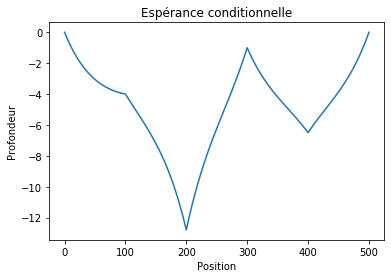

In [45]:
n=len(depth)
esp_cond_unkown_points=mu*np.ones(N-n)+ (CXY.dot(np.linalg.inv(CY))).dot(depth-mu*np.ones(n))


esp=np.zeros(N)
j=0
for i in range(N):
    if i in observation_indexes:
        esp[i]=depth[j]
        j+=1
    else:
        esp[i]=esp_cond_unkown_points[i-j]

plt.plot(discretization,esp)
plt.title("Espérance conditionnelle")
plt.ylabel("Profondeur")
plt.xlabel("Position")
plt.show()

Calculons alors la matrice de variance conditionnelle.

In [46]:
def covariance_cond_all(depth,mu):
    return CX - np.dot(CXY,np.dot(np.linalg.inv(CY),CYX))

Extrayons-en la variance conditionnelle en fonction de la position.

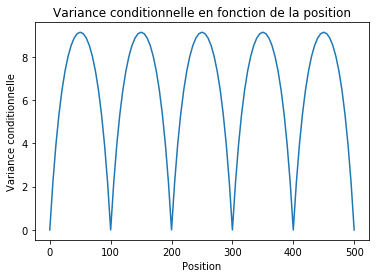

In [48]:
def var_cond(depth,mu):
    cov=covariance_cond_all(depth,mu)
    var=np.zeros(N)
    j=0
    for i in range(N):
        if i in observation_indexes:
            j+=1
        else:
            var[i]=cov[i-j][i-j]
    return var


var=var_cond(depth,mu)

plt.plot(discretization,var)
plt.title("Variance conditionnelle en fonction de la position")
plt.xlabel("Position")
plt.ylabel("Variance conditionnelle")
plt.show()

La variance est un indice de dispersion. Connaissant les valeurs pour $x=0,100,200,300,400,500$, la variance en ces points est nulle. Ensuite, plus on est éloigné de ces valeurs, plus la variance est grande, c'est à dire que plus on est éloigné d'une observation, moins on a d'information sur la profondeur, ce qui correspond à l'intuition. 

Nous pouvons à présent réaliser une simulation conditionnelle en utilisant la décomposition de cholesky de la matrice de covariance conditionnelle.

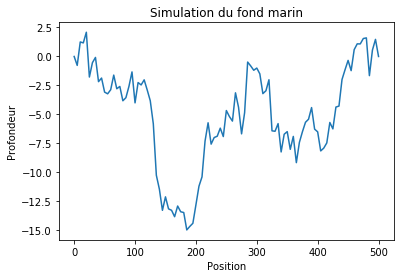

In [55]:
R = np.linalg.cholesky(covariance_cond_all(depth,mu))

def simulation(mu,sigma2,a,unknown_indexes,depth):
    Y = np.random.normal(0,1,N-n)
    sim = esp_cond_unkown_points + R.dot(Y)
    sim_all = np.zeros(N)
    j=0
    for i in range(N):
        if i in observation_indexes:
            sim_all[i] = depth[j]
            j+=1
        else:
            sim_all[i]=sim[i-j]
    return sim_all

simu = simulation(mu,sigma2,a,unknown_indexes,depth)
simu1 = simulation(mu,sigma2,a,unknown_indexes,depth)

plt.plot(discretization,simu)
plt.title("Simulation du fond marin")
plt.xlabel("Position")
plt.ylabel("Profondeur")
plt.show()

Nous remarquons que d'une simulation à l'autre, l'aspect du fond marin peut-être assez différent.

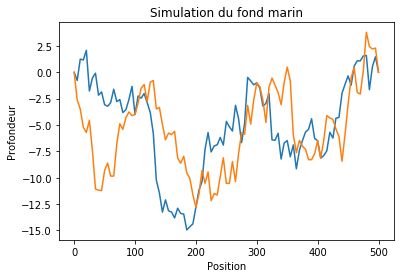

In [56]:
plt.plot(discretization,simu)
plt.plot(discretization,simu1)
plt.title("Simulation du fond marin")
plt.xlabel("Position")
plt.ylabel("Profondeur")
plt.show()

Nous pouvons alors calculer la longueur de fond marin à partir de ces simulations.

In [57]:
def length(depth_all,Delta):
    length=0
    for i in range(1,N):
        z = depth_all[i]-depth_all[i-1]
        length+=np.sqrt(Delta**2+z**2)
    return length

In [59]:
simulations_number = 100

length_list = np.array([length(simulation(mu,sigma2,a,unknown_indexes,depth),Delta) for i in range(simulations_number)])

length_expected_value = np.average(length_list)
length_cond_expected_value = length(esp , Delta)

print("La longueur du câble à partir de 100 simulations : ", length_expected_value)
print("L’espérance conditionnelle de la longueur avec la longueur de l’espérance conditionnelle : ",length_cond_expected_value)
print("La différence entre les deux est : ", np.abs(length_expected_value-length_cond_expected_value))
print("La différence relative entre les deux est : ", (np.abs(length_expected_value-length_cond_expected_value)/min(length_cond_expected_value,length_expected_value))*100,"%")

La longueur du câble à partir de 100 simulations :  522.5273456192579
L’espérance conditionnelle de la longueur avec la longueur de l’espérance conditionnelle :  501.6468416918411
La différence entre les deux est :  20.880503927416783
La différence relative entre les deux est :  4.162391186795024 %


Il y a une différence significative entre l'espérance conditionnelle estimée de la longueur avec la longueur de l'espérance conditionnelle. Cela s'explique par le fait que l'espérance conditionnelle du fond marin tend à gommer les aspérités du fond marin, qui tendent à augmenter la longueur de câble nécessaire.

Si l'on représente la suite $M_n$ des moyennes des longueurs de câbles nécessaires en fontion du nombre de simulations effectuées :

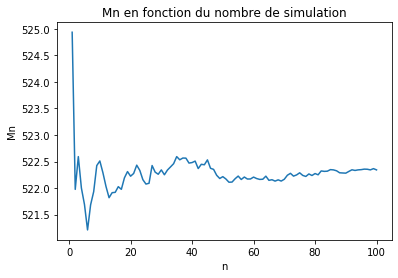

In [66]:
def M(n):
    expected_length = 0
    for i in range(n):
        expected_length += length(simulation(mu,sigma2,a,unknown_indexes,depth),Delta)/n
    return expected_length


def list_M_n(n):
    expected_length = length(simulation(mu,sigma2,a,unknown_indexes,depth),Delta)
    list=[expected_length]
    for i in range(1,n):
        l = length(simulation(mu,sigma2,a,unknown_indexes,depth),Delta)
        list += [(list[i-1]*i+l)/(i+1)]
    return list

simulations_number_list = [i+1 for i in range(simulations_number)]

length_list_n = np.array(list_M_n(simulations_number))
plt.plot(simulations_number_list,length_list_n)
plt.title("Mn en fonction du nombre de simulation")
plt.xlabel("n")
plt.ylabel("Mn")
plt.show()


On observe que $M_n$ converge vers une valeur proche de 522 après un nombre restreint de simulations. On pourra améliorer l'estimation en augmentant le nombre de simulation. L'erreur relative commise en ne considérant que l'espérance de la profondeur et non les simulation converge également vers une valeur proche de 4.1%

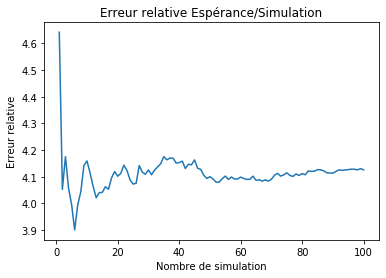

In [70]:
relative_error = (length_list_n/length_cond_expected_value - np.array([1.0]))*100
plt.plot(simulations_number_list,relative_error)
plt.title("Erreur relative Espérance/Simulation")
plt.xlabel("Nombre de simulation")
plt.ylabel("Erreur relative")
plt.show()